Define constants and path variables

In [317]:
import numpy as np
import matplotlib.image as mpimg
import cv2
from matplotlib import pyplot as plt
from os import path, listdir

BASE_PATH = !pwd
TRAIN_PATH = BASE_PATH[0] + '/TRAIN_IMAGES/'

MAX_CONTOURS = 30
IMAGE_SIZE = (1600, 900)

# Epsilon ratio for approxPolyDP
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
EPSILON_RATIO = 0.03

Define helper functions for:
- Ploting images
- Listing all image files

In [318]:
def plot_image(img_data):
    plt.imshow(img_data)
    plt.axis('off')  # to hide the axes
    plt.show()

def get_all_files():
    for file_name in [item for item in listdir(TRAIN_PATH) if path.isfile(TRAIN_PATH + item)]:
        yield TRAIN_PATH + file_name

file_list = list(get_all_files())

Main processing class

In [319]:
class ImageFile:
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_data = cv2.imread(file_name)
        self.file_data = cv2.resize(self.file_data, IMAGE_SIZE) 
        self.file_data = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2RGB)
    
    """
    Thresholding the file. GaussianBlur is applied to improve thresholding result
    For the bluring operation, we can use either
    - GaussianBlur (faster) or
    - BilateralFilter (better at preserving edges)
    For the thresholding operation, we can use either
    - Adaptive threshold (slower) or 
    - OTSU threshold (global min variance)
    Alternatively, we can use an edge detection algorithm
    References:
    https://docs.opencv.org/3.3.1/d7/d4d/tutorial_py_thresholding.html
    https://docs.opencv.org/3.3.1/da/d22/tutorial_py_canny.html
    """
    def preprocess(self):
        # Grayscaling
        gray_img = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2GRAY)
        # Bluring
        blur_img = cv2.GaussianBlur(gray_img, (5,5), 0)
#         blur_img = cv2.bilateralFilter(gray_img,9,75,75)
        # Thresholding
#         thres_img = cv2.adaptiveThreshold(blur_img,
#             255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
        thres_level, thres_img = cv2.threshold(blur_img,
            0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thres_img
        # Edge detection
#         edged = cv2.Canny(blur_img, 100, 200)
#         return edged

    """
    References:
    https://docs.opencv.org/2.4/doc/tutorials/imgproc/shapedescriptors/find_contours/find_contours.html
    """
    def find_cards(self, preprocessed_img):
        dummy, contours, hierachy = cv2.findContours(preprocessed_img, 
            cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_SIMPLE)
        contour_areas = [cv2.contourArea(cnt) for cnt in contours]
        
        # sort the contours by area
        index_sort = sorted(range(len(contours)), 
            key=lambda idx : contour_areas[idx], 
            reverse=True)
        
        # limit number of contours for processing
        if MAX_CONTOURS is not None and len(index_sort) > MAX_CONTOURS:
            index_sort = index_sort[:MAX_CONTOURS]
            
        for idx in index_sort:
            peri = cv2.arcLength(contours[idx], True)
            approx = cv2.approxPolyDP(contours[idx], EPSILON_RATIO * peri, True)
            
            # pick contours with no parents and 4 corners
            # additionally, limit area of the contour (using contour_areas)
            if len(approx) == 4 and hierachy[0][idx][3] == -1:
#                 yield contours[idx]
                yield approx
                
    def get_perspective_transform(self, contour):
        x, y, width, height = cv2.boundingRect(contour)
        
        points = contour.reshape(4, 2)
#         print(points)
        
        rect = np.zeros((4, 2), dtype = 'float32')
        
        sum_pts = points.sum(axis = 1)
        rect[0] = points[np.argmin(sum_pts)]
        rect[2] = points[np.argmax(sum_pts)]

        diff_pts = np.diff(points, axis = 1)
        rect[1] = points[np.argmin(diff_pts)]
        rect[3] = points[np.argmax(diff_pts)]
        
        is_horizontal = False
        
#         print((width, height))
        # if card is vertically oriented
        if (width <= 0.8 * height):
            print('orientation: vertical')
            (bl, tl, tr, br) = rect
            
        elif (width >= 1.2 * height): # if card is horizontally oriented
            print('orientation: horizontal')
            (tl, tr, br, bl) = rect
            is_horizontal = True # indicates the card needs to be rotated
            
        else: # if card is diamond oriented
            if points[1][0] <= points[3][0]: # If card is tilted to the left
                print('orientation: diamond - tilted left')
                tl = points[0][0]
                tr = points[3][0]
                br = points[2][0]
                bl = points[1][0]
            else: # if card is tilted to the right
                print('orientation: diamond - tilted right')
                tl = points[1][0]
                tr = points[0][0]
                br = points[3][0]
                bl = points[2][0]
            # finally assigns coordinates to the rect
            (tl, tr, br, bl) = rect
        
        # find distances between points
        
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        
        maxWidth = int(max(widthA, widthB))
        maxHeight = int(max(heightA, heightB))
        
        destination = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]
            ], dtype = 'float32')
        
        perspective_transform = cv2.getPerspectiveTransform(rect, destination)
        
        warped = cv2.warpPerspective(self.file_data, perspective_transform, (maxWidth, maxHeight))
        
        return (x, y), warped, is_horizontal

Display the preprocessing results

(900, 1600)


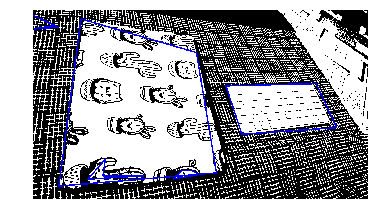

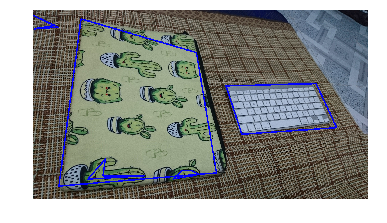

In [320]:
img_file = ImageFile(file_list[1])
img_data = img_file.preprocess()

# Dimensions of the image
print(np.shape(img_data))

contours = list(img_file.find_cards(img_data))

img_data = np.stack((img_data,)*3, axis=-1)

if len(contours) > 0:
    cv2.drawContours(img_data, contours, -1, (0, 0, 255), 5)
# Plot the preprocessed file
plot_image(img_data)

# Draw the original image with contours
img_data = img_file.file_data.copy()

if len(contours) > 0:
    cv2.drawContours(img_data, contours, -1, (0, 0, 255), 5)

plot_image(img_data)

- Perspective transform using the extracted contours.
- Rotate the extracted image if necessary

orientation: diamond - tilted left
Rect coordinates: (123, 42)


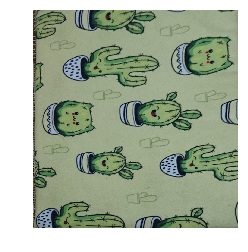

orientation: horizontal
rotated
Rect coordinates: (921, 350)


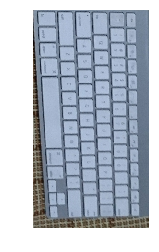

orientation: horizontal
rotated
Rect coordinates: (262, 708)


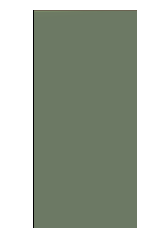

orientation: horizontal
rotated
Rect coordinates: (669, 763)


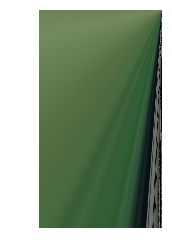

orientation: horizontal
rotated
Rect coordinates: (0, 25)


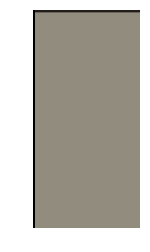

In [321]:
for contour in contours:
    (x, y), warped, is_horizontal = img_file.get_perspective_transform(contour)
    
    # rotate the image
    if is_horizontal:
        # rotate the image
        rows, cols, channels = warped.shape
        (cX, cY) = (cols // 2, rows // 2)
        rotation_matrix = cv2.getRotationMatrix2D((cX, cY), -90, 1)
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])
        nW = int((rows * sin) + (cols * cos))
        nH = int((rows * cos) + (cols * sin))
        rotation_matrix[0, 2] += (nW / 2) - cX
        rotation_matrix[1, 2] += (nH / 2) - cY
        warped = cv2.warpAffine(warped, rotation_matrix, (nW, nH))
        print('rotated')

    print('Rect coordinates: %s' % str((x, y)))
    plot_image(warped)